In [177]:
import mne
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from mne.preprocessing import ICA
from mne.decoding import CSP
#import ssm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [178]:
# Load the EEG data
raw = mne.io.read_raw_brainvision(r'data\sub-01\eeg\sub-01_task-MOBAgame_eeg.vhdr', preload=False)

Extracting parameters from data\sub-01\eeg\sub-01_task-MOBAgame_eeg.vhdr...
Setting channel info structure...


In [198]:
# Step 2: Load the event markers
events_df = pd.read_csv(r'data\derivatives\markers\sub-01_task-MOBAgame_marker.txt', delim_whitespace=True)
events_array = events_df.to_numpy().astype(int)

# Step 3: Prepare events_mne
events_mne = np.column_stack((
    events_array[:, 0],  # latency in samples
    np.zeros(len(events_array), dtype=int),  # dummy value
    events_array[:, 1]   # event type
)).astype(int)

# Step 4: Define event_id dictionary including all event types
unique_event_ids = np.unique(events_mne[:, 2])
print(f"Unique event IDs: {unique_event_ids}")

# Define event_id based on your dataset
event_id = {
    'Kill': 13,
    'Death': 14,
    'Game Start': 66,
    'Game Victory': 666,
    'Game Failure': 444,
}

# Check for missing event IDs
missing_events = set(unique_event_ids) - set(event_id.values())
if missing_events:
    print(f"Warning: The following event IDs are not in the event_id dictionary and will be ignored: {missing_events}")

print(events_mne)


Unique event IDs: [ 13  14  66 444 666]
[[  66435       0      66]
 [ 291375       0      13]
 [ 448220       0      13]
 [ 601308       0      14]
 [ 683418       0      13]
 [ 800408       0      13]
 [ 936417       0      13]
 [1019663       0      14]
 [1177826       0      13]
 [1230205       0      13]
 [1234544       0      13]
 [1287744       0      13]
 [1404706       0      13]
 [1520628       0      13]
 [1526107       0      14]
 [1527590       0     444]
 [1756005       0      66]
 [1802882       0      13]
 [1817817       0      13]
 [1874313       0      13]
 [2113766       0      13]
 [2130345       0      13]
 [2215606       0      14]
 [2796531       0      14]
 [2941737       0      13]
 [2945655       0     666]
 [3206623       0      66]
 [3420966       0      13]
 [3427693       0      14]
 [3559564       0      13]
 [3843937       0      14]
 [3894642       0      13]
 [3965692       0      13]
 [4024901       0      14]
 [4104439       0      14]
 [4248159      

C:\Users\amang\AppData\Local\Temp\ipykernel_356\3974735868.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  events_df = pd.read_csv(r'data\derivatives\markers\sub-01_task-MOBAgame_marker.txt', delim_whitespace=True)


In [187]:
def custom_epoch_extraction(raw, events, event_types, tmin_std=-2.0, tmax_std=2.0, proximity=3.0):
    """
    Extracts EEG segments around events with custom logic based on event proximity.
    Adjusts event sample indices to match the concatenated raw data.
    Returns:
    - concatenated_raw: Concatenated Raw object containing all extracted segments
    - adjusted_events: Events with sample indices adjusted to the concatenated raw data
    """
    # Filter events by type
    events = np.array([e for e in events if e[2] in event_types])
    
    # Initialize lists
    segments = []
    adjusted_events = []
    cumulative_samples = 0  # Tracks the total samples in concatenated data
    
    sfreq = raw.info['sfreq']
    
    for i, event in enumerate(events):
        event_id = event[2]
        event_sample = event[0]
        event_time = event_sample / sfreq
        
        # Use standard tmin and tmax
        tmin = tmin_std
        tmax = tmax_std
        
        # Adjust tmin and tmax based on proximity to data boundaries
        epoch_start = event_time + tmin
        epoch_end = event_time + tmax
        
        # Adjust epoch window if it exceeds data boundaries
        if epoch_start < raw.times[0]:
            epoch_start = raw.times[0]
        if epoch_end > raw.times[-1]:
            epoch_end = raw.times[-1]
        
        # Skip invalid epochs
        if epoch_start >= epoch_end:
            print(f"Event at {event_time:.2f}s: Invalid epoch window after adjustment. Skipping event.")
            continue
        
        # Extract segment
        segment = raw.copy().crop(tmin=epoch_start, tmax=epoch_end)
        segments.append(segment)
        
        # Adjust event sample index for concatenated data
        adjusted_sample = cumulative_samples + int((event_time - epoch_start) * sfreq)
        adjusted_events.append([adjusted_sample, 0, event_id])
        
        # Update cumulative samples
        cumulative_samples += len(segment.times)
    
    if segments:
        concatenated_raw = mne.concatenate_raws(segments)
        adjusted_events = np.array(adjusted_events).astype(int)
        return concatenated_raw, adjusted_events
    else:
        print("No valid segments were extracted.")
        return None, None


epochs_raw, adjusted_events = custom_epoch_extraction(
    raw,
    events_mne,
    event_types=list(event_id.values()),
    tmin_std=-0.5,
    tmax_std=1.5,
    proximity=3.0
)

# Check if segments were extracted
if epochs_raw is not None:
    # Save the reduced data
    epochs_raw.save('subject1_reduced.fif', overwrite=True)
    print("Reduced data saved as 'subject1_reduced.fif'.")
else:
    print("No segments were extracted. Please review the event timings and epoch extraction criteria.")

# Step 6: Load the Reduced Data
if epochs_raw is not None:
    raw_clean = mne.io.read_raw_fif('subject1_reduced.fif', preload=True)
else:
    raise ValueError("Reduced data not found. Please ensure that segments were successfully extracted.")


Overwriting existing file.
Writing C:\Users\amang\courses\eeg-hidden-markov-model\subject1_reduced.fif


C:\Users\amang\AppData\Local\Temp\ipykernel_356\3907038202.py:75: RuntimeWarning: This filename (C:\Users\amang\courses\eeg-hidden-markov-model\subject1_reduced.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  epochs_raw.save('subject1_reduced.fif', overwrite=True)


Closing C:\Users\amang\courses\eeg-hidden-markov-model\subject1_reduced.fif
[done]
Reduced data saved as 'subject1_reduced.fif'.
Opening raw data file subject1_reduced.fif...
Isotrak not found
    Range : 65935 ... 244023 =     65.935 ...   244.023 secs
Ready.
Reading 0 ... 178088  =      0.000 ...   178.088 secs...


C:\Users\amang\AppData\Local\Temp\ipykernel_356\3907038202.py:82: RuntimeWarning: This filename (subject1_reduced.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean = mne.io.read_raw_fif('subject1_reduced.fif', preload=True)


In [188]:
# Apply bandpass filtering
raw_clean.filter(1., 40., fir_design='firwin', verbose=True)

# Perform ICA for artifact removal
ica = ICA(n_components=15, random_state=97, max_iter='auto')
ica.fit(raw_clean)

# Define surrogate EOG channels and detect artifacts
eog_channels = ['FP1', 'FP2']
eog_inds = []
for ch in eog_channels:
    if ch in raw_clean.ch_names:
        inds, scores = ica.find_bads_eog(raw_clean, ch_name=ch)
        eog_inds.extend(inds)
ica.exclude = list(set(eog_inds))
ica.apply(raw_clean)


Filtering raw data in 89 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



C:\Users\amang\AppData\Local\Temp\ipykernel_356\3738920607.py:2: RuntimeWarning: filter_length (3301) is longer than the signal (2001), distortion is likely. Reduce filter length or filter a longer signal.
  raw_clean.filter(1., 40., fir_design='firwin', verbose=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 66 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.9s.
Using EOG channel: FP1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-1

<Raw | subject1_reduced.fif, 67 x 178089 (178.1 s), ~91.1 MB, data loaded>

In [189]:
unique_event_ids = np.unique(events_mne[:, 2])
print("Unique event IDs in events_mne:", unique_event_ids)


Unique event IDs in events_mne: [ 13  14  66 444 666]


In [190]:
from collections import Counter

event_counts = Counter(events_mne[:, 2])
print("Event counts:", event_counts)

Event counts: Counter({np.int64(13): 53, np.int64(14): 22, np.int64(66): 7, np.int64(666): 6, np.int64(444): 1})


In [191]:
print(raw_clean.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG, 1 misc
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 67
 projs: []
 sfreq: 1000.0 Hz
>


In [192]:
# Define surrogate EOG channels
eog_channels = ['FP1', 'FP2']

# Check available surrogate EOG channels
available_eog_channels = [ch for ch in eog_channels if ch in raw_clean.ch_names]
print(f"Available surrogate EOG channels: {available_eog_channels}")

# Initialize list to hold bad component indices
eog_inds = []

# Detect EOG artifacts using available surrogate channels
for ch in available_eog_channels:
    inds, scores = ica.find_bads_eog(raw_clean, ch_name=ch)
    print(f"Detected EOG components for channel {ch}: {inds}")
    eog_inds.extend(inds)

# Remove duplicate indices
eog_inds = list(set(eog_inds))
ica.exclude = eog_inds
print(f"ICA components to exclude: {ica.exclude}")

# Apply ICA to remove artifacts
raw_clean = raw_clean.copy()
ica.apply(raw_clean)
print("ICA applied to clean data.")

Available surrogate EOG channels: ['FP1', 'FP2']
Using EOG channel: FP1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwid

In [193]:
sfreq = raw_clean.info['sfreq']
data_start = raw_clean.times[0]
data_end = raw_clean.times[-1]

# Identify events causing issues
invalid_event_indices = []
for idx, event in enumerate(valid_events):
    event_sample = event[0]
    event_time = event_sample / sfreq
    epoch_start = event_time + tmin
    epoch_end = event_time + tmax

    if epoch_start < data_start or epoch_end > data_end:
        print(f"Event at {event_time:.2f}s is too close to data boundaries.")
        invalid_event_indices.append(idx)

Event at 291.38s is too close to data boundaries.
Event at 448.22s is too close to data boundaries.
Event at 601.31s is too close to data boundaries.
Event at 683.42s is too close to data boundaries.
Event at 800.41s is too close to data boundaries.
Event at 936.42s is too close to data boundaries.
Event at 1019.66s is too close to data boundaries.
Event at 1177.83s is too close to data boundaries.
Event at 1230.20s is too close to data boundaries.
Event at 1234.54s is too close to data boundaries.
Event at 1287.74s is too close to data boundaries.
Event at 1404.71s is too close to data boundaries.
Event at 1520.63s is too close to data boundaries.
Event at 1526.11s is too close to data boundaries.
Event at 1527.59s is too close to data boundaries.
Event at 1756.01s is too close to data boundaries.
Event at 1802.88s is too close to data boundaries.
Event at 1817.82s is too close to data boundaries.
Event at 1874.31s is too close to data boundaries.
Event at 2113.77s is too close to dat

Not setting metadata
88 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 88 events and 1501 original time points ...
87 bad epochs dropped
Applying baseline correction (mode: mean)
Total epochs: 1
Event counts after epoching: {'Kill': 13, 'Death': 14, 'Game Start': 66, 'Game Victory': 666, 'Game Failure': 444}
All epochs were dropped. Inspecting drop log...
Drop log: ((), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SHORT',), ('TOO_SH

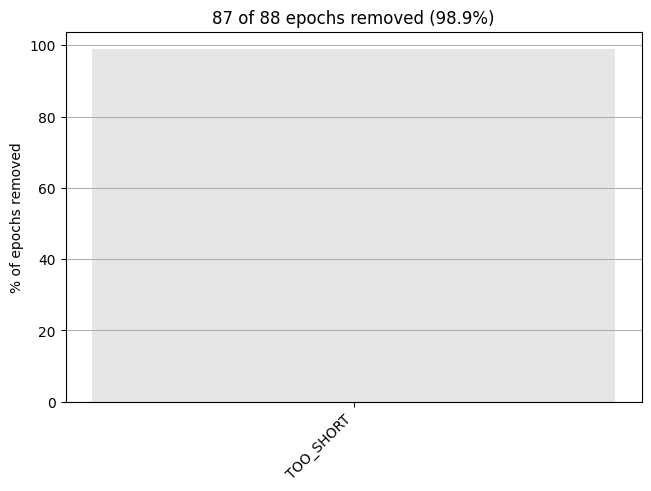

In [195]:
tmin, tmax = -0.5, 1.0  # Time window around each event

epochs = mne.Epochs(
    raw_clean,
    valid_events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    preload=True,
    picks='eeg',                  # Use only EEG channels
    reject=None,                  # Do not reject epochs based on amplitude
    flat=None,                    # Do not reject epochs based on flat signals
    reject_by_annotation=False,   # Do not reject epochs based on annotations
    verbose=True
)

# Apply baseline correction
epochs.apply_baseline(baseline=(None, 0))

# Step 11: Verify Epoch Counts
print(f"Total epochs: {len(epochs)}")
print("Event counts after epoching:", epochs.event_id)

# If epochs are still being dropped, inspect the drop log
if len(epochs) < 80:
    print("All epochs were dropped. Inspecting drop log...")
    print("Drop log:", epochs.drop_log)
    epochs.plot_drop_log()
else:
    print("Epochs successfully created.")


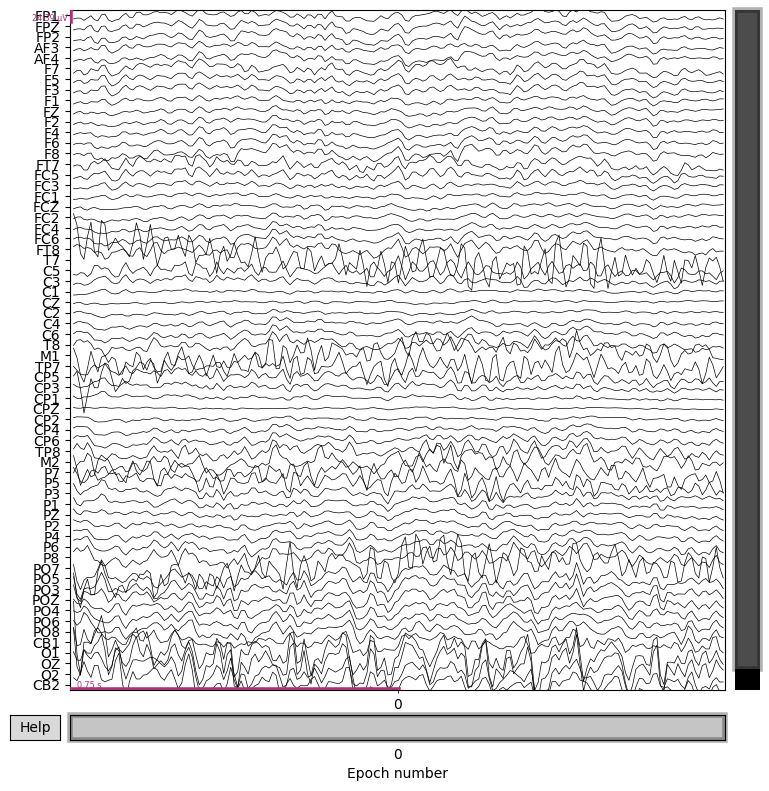

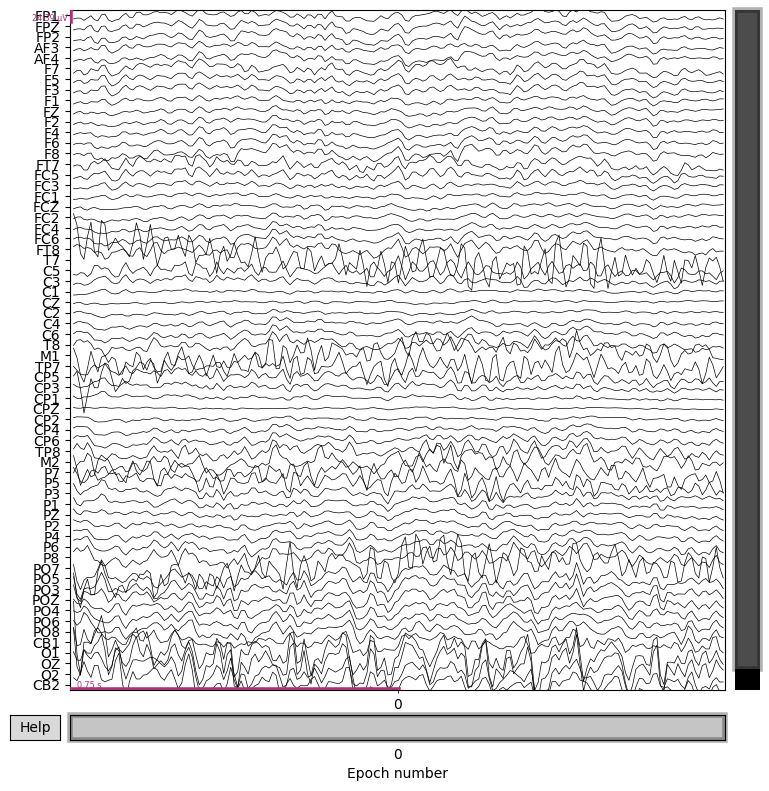

In [196]:
%matplotlib inline

# Plot epochs
epochs.plot(n_channels=64, scalings='auto', n_epochs=10)


In [52]:
data_duration = raw_clean.times[-1]
print(f"Data duration: {data_duration:.2f} seconds")


Data duration: 267.09 seconds


In [55]:
sfreq = raw_clean.info['sfreq']
out_of_bounds_events = []

for event in events_mne:
    event_time = event[0] / sfreq
    epoch_start = event_time + tmin
    epoch_end = event_time + tmax
    if epoch_start < 0 or epoch_end > data_duration:
        out_of_bounds_events.append(event)

print(f"Number of out-of-bounds events: {len(out_of_bounds_events)}")

Number of out-of-bounds events: 88


In [ ]:
# Get data
X = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)

# Flatten data: (n_epochs, n_channels * n_times)
n_epochs, n_channels, n_times = X.shape
X_flat = X.reshape(n_epochs, n_channels * n_times)

# Initialize PCA
pca = PCA(n_components=2)

# Fit and transform the data
X_pca = pca.fit_transform(X_flat)


In [36]:
# Map labels to integers
label_map = {'Kill': 0, 'Death': 1}
y = np.array([label_map[epochs.events[i, 2]] for i in range(len(epochs))])

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['Kill', 'Death'])
plt.title('PCA of EEG Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


NameError: name 'X_pca' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
# Initialize feature matrix and labels
features = []
labels = []

for epoch, event in zip(epochs.get_data(), epochs.events[:, 2]):
    # Statistical features per channel
    mean = epoch.mean(axis=1)
    var = epoch.var(axis=1)
    skewness = skew(epoch, axis=1)
    kurt = kurtosis(epoch, axis=1)
    
    # Concatenate features
    epoch_features = np.concatenate([mean, var, skewness, kurt])
    features.append(epoch_features)
    labels.append(event)

X_stat = np.array(features)
y = np.array(labels)


In [ ]:
# Map labels to binary values
y_binary = np.array([0 if event == 13 else 1 for event in y])  # 0: Kill, 1: Death

# Initialize CSP
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Fit CSP
X_csp = csp.fit_transform(epochs.get_data(), y_binary)


In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_stat)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_binary, cmap='viridis', alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=['Kill', 'Death'])
plt.title('t-SNE of EEG Statistical Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# For statistical features
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_binary, test_size=0.2, random_state=42)

# For CSP features
X_train_csp, X_test_csp, y_train_csp, y_test_csp = train_test_split(X_csp, y_binary, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the classifier
clf_stat = LogisticRegression(solver='liblinear', random_state=42)

# Train the classifier
clf_stat.fit(X_train_stat, y_train_stat)

# Predict
y_pred_stat = clf_stat.predict(X_test_stat)

# Evaluate
print("Logistic Regression with Statistical Features")
print(classification_report(y_test_stat, y_pred_stat, target_names=['Kill', 'Death']))


In [ ]:
# Initialize the classifier
clf_csp = LogisticRegression(solver='liblinear', random_state=42)

# Train the classifier
clf_csp.fit(X_train_csp, y_train_csp)

# Predict
y_pred_csp = clf_csp.predict(X_test_csp)

# Evaluate
print("Logistic Regression with CSP Features")
print(classification_report(y_test_csp, y_pred_csp, target_names=['Kill', 'Death']))
